In [1]:
# See https://confluence.ecmwf.int/display/CKB/ERA5%3A+compute+pressure+and+geopotential+on+model+levels%2C+geopotential+height+and+geometric+height
from pathlib import Path

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from xgcm import Grid

from mcs_prime import PATHS
%matplotlib inline

In [2]:
e5datadir = PATHS['era5dir'] / 'data/oper/an_ml/2019/06/01'
h = 0
e5lnsp = xr.open_dataarray(e5datadir / f'ecmwf-era5_oper_an_ml_20190601{h:02d}00.lnsp.nc').sel(latitude=slice(60, -60))
e5u = xr.open_dataarray(e5datadir / f'ecmwf-era5_oper_an_ml_20190601{h:02d}00.u.nc').sel(latitude=slice(60, -60))
df_ecmwf = pd.read_csv(PATHS['datadir'] / 'ecmwf_L137_model_level_definitions.csv')

In [3]:
sp = np.exp(e5lnsp).values[0] / 100  # pressure in hPa.
a = df_ecmwf['a [Pa]'].values / 100  # a now in hPa.
b = df_ecmwf.b.values

In [4]:
# Broadcasting to correctly calc 3D pressure field.
p_half = a[:, None, None] + b[:, None, None] * sp[None, :, :]
p_ml = (p_half[:-1] + p_half[1:]) / 2

In [5]:
da_p = xr.DataArray(
    p_ml,
    dims=['level', 'latitude', 'longitude'],
    coords=dict(
        level=e5u.level,
        latitude=e5lnsp.latitude,
        longitude=e5lnsp.longitude,
    ),
    attrs=dict(
        units='hPa',
        standard='air_pressure',
    )
)

In [10]:
# This is amazingly easy AND amazingly powerful.
# Interpolate u onto 4x pressure levels.
ds_p = da_p.to_dataset(name='pressure')
grid = Grid(ds_p, coords=dict(pressure={'center': 'level'}), periodic=False)
u_plev = grid.transform(
    e5u,
    'pressure',
    np.array([1000, 900, 800, 700]),
    target_data=ds_p.pressure,
    method='linear'
)

u_plev = u_plev.transpose('time', 'pressure', 'latitude', 'longitude')

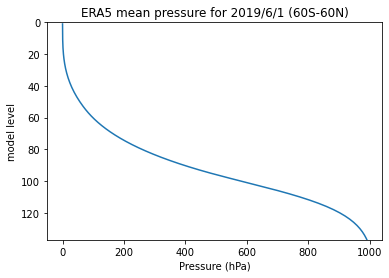

In [7]:
plt.figure()
plt.plot(p_ml.mean(axis=(1, 2)), range(1, 138))
plt.ylim((137, 0))
plt.xlabel('Pressure (hPa)')
plt.ylabel('model level')
plt.title('ERA5 mean pressure for 2019/6/1 (60S-60N)');

119 901.7781984910924
111 803.8734986370798


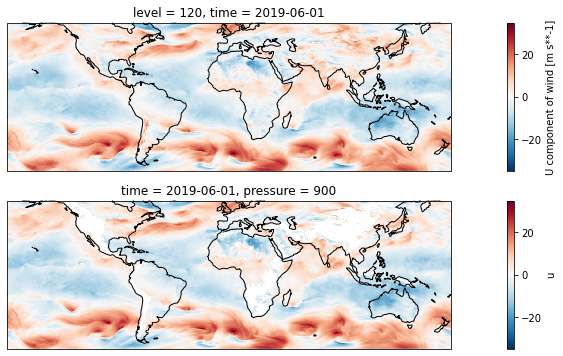

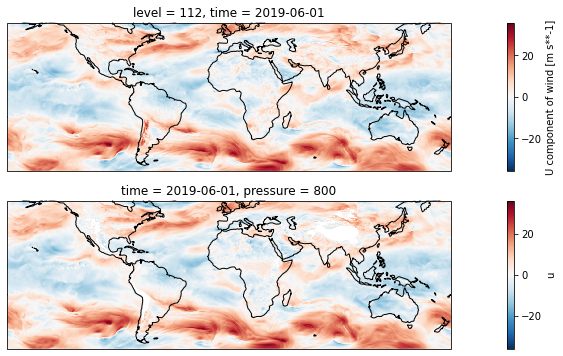

In [8]:
for pressure in [900, 800]:
    idx = np.abs(p_ml.mean(axis=(1, 2)) - pressure).argmin()
    print(idx, da_p.isel(level=idx).mean().values.item())
    fig, (ax0, ax1) = plt.subplots(2, 1, subplot_kw={'projection': ccrs.PlateCarree()})
    fig.set_size_inches(20, 6)
    e5u.isel(level=idx).plot(ax=ax0)
    u_plev.sel(pressure=pressure).plot(ax=ax1)
    ax0.coastlines()
    ax1.coastlines()